In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !unzip 'cityscapes_data.zip'

## DATA

In [3]:
train_fns = os.listdir(os.path.join('cityscapes_data', 'train'))
val_fns = os.listdir(os.path.join('cityscapes_data', 'val'))
print(len(train_fns), len(val_fns))

2975 500


cityscapes_data/train/15.jpg


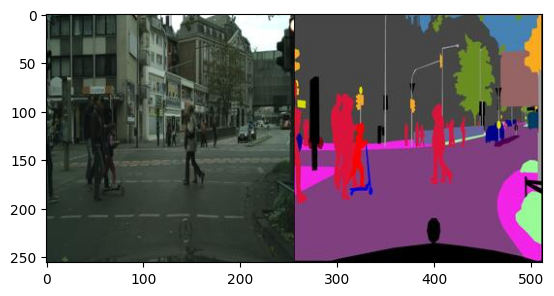

In [4]:
sample_image_fp = os.path.join(os.path.join('cityscapes_data', 'train'), '15.jpg')
sample_image = Image.open(sample_image_fp).convert('RGB')
plt.imshow(sample_image)
print(sample_image_fp)

In [5]:
def split_images(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

Sample image shape: (256, 512, 3)


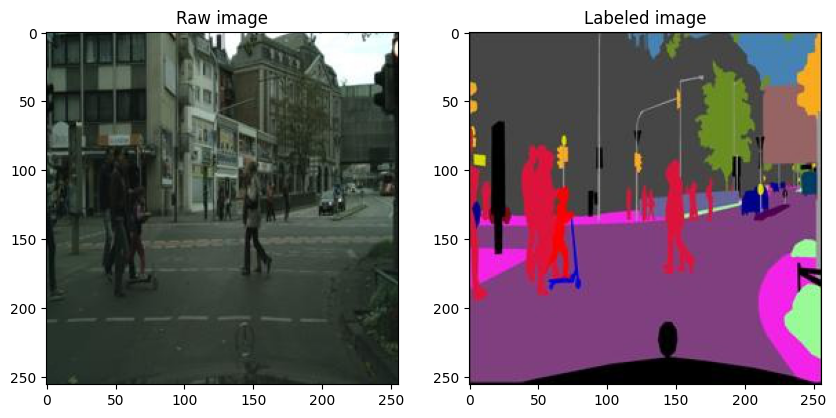

In [6]:
sample_image = np.array(sample_image)
print(f'Sample image shape: {sample_image.shape}')

cityscape, label = split_images(sample_image)
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

axes[0].set_title('Raw image')
axes[1].set_title('Labeled image')

plt.show()

## LABELS

In [7]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[148 206 171]
 [ 25 124 125]
 [229  84 111]
 [229 248 112]
 [  4 127 206]]


In [8]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

label_model.predict(color_array[:5, :])

array([4, 2, 3, 8, 1], dtype=int32)

Label classes: [[6 6 6 ... 6 6 6]
 [6 6 6 ... 0 3 6]
 [6 6 6 ... 8 8 6]
 ...
 [6 6 6 ... 7 7 6]
 [6 6 6 ... 7 6 6]
 [6 6 6 ... 6 6 6]]


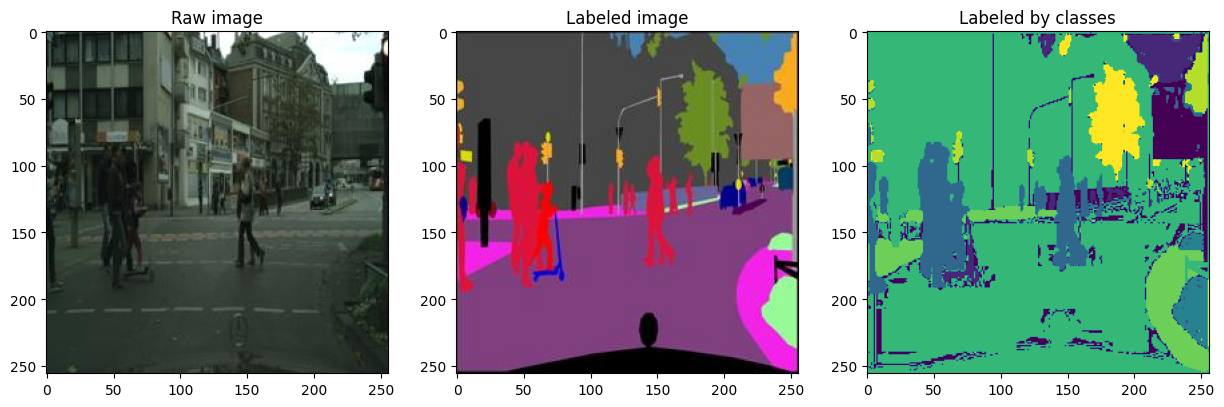

In [9]:
cityscape, label = split_images(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

axes[0].set_title('Raw image')
axes[1].set_title('Labeled image')
axes[2].set_title('Labeled by classes')

print(f'Label classes: {label_class}')

plt.show()

## Define dataset for further analysis

In [10]:
class CityDataset(Dataset):
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.image_fns[idx])).convert('RGB')
        image = np.array(image)

        cityscape, label = self.split_images(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_images(self, input):
        image = np.array(input)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [11]:
train_data = CityDataset(os.path.join('cityscapes_data', 'train'), label_model)

In [12]:
print(f'Size of train dataset: {len(train_data)}')

Size of train dataset: 2975


In [13]:
cityscape, label_class = train_data[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


## U-net

![u-net-architecture-2.png](attachment:u-net-architecture-2.png)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Define U-Net model

In [15]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        self.n_classes = num_classes

        self.contraction_1_1 = self.conv_block(in_channels=3, out_channels=64)
        self.contraction_1_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.contraction_2_1 = self.conv_block(in_channels=64, out_channels=128)
        self.contraction_2_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.contraction_3_1 = self.conv_block(in_channels=128, out_channels=256)
        self.contraction_3_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.contraction_4_1 = self.conv_block(in_channels=256, out_channels=512)
        self.contraction_4_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.middle_block = self.conv_block(512, 1024)

        self.expansion_1_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansion_1_2 = self.conv_block(in_channels=1024, out_channels=512)

        self.expansion_2_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansion_2_2 = self.conv_block(in_channels=512, out_channels=256)

        self.expansion_3_1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansion_3_2 = self.conv_block(in_channels=256, out_channels=128)

        self.expansion_4_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansion_4_2 = self.conv_block(in_channels=128, out_channels=64)

        self.output_layer = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contraction_1_1_res = self.contraction_1_1(X)
        contraction_1_2_res = self.contraction_1_2(contraction_1_1_res)

        contraction_2_1_res = self.contraction_2_1(contraction_1_2_res)
        contraction_2_2_res = self.contraction_2_2(contraction_2_1_res)

        contraction_3_1_res = self.contraction_3_1(contraction_2_2_res)
        contraction_3_2_res = self.contraction_3_2(contraction_3_1_res)

        contraction_4_1_res = self.contraction_4_1(contraction_3_2_res)
        contraction_4_2_res = self.contraction_4_2(contraction_4_1_res)

        middle_res = self.middle_block(contraction_4_2_res)

        expansion_1_1_res = self.expansion_1_1(middle_res)
        expansion_1_2_res = self.expansion_1_2(torch.cat((expansion_1_1_res, contraction_4_1_res), dim=1))

        expansion_2_1_res = self.expansion_2_1(expansion_1_2_res)
        expansion_2_2_res = self.expansion_2_2(torch.cat((expansion_2_1_res, contraction_3_1_res), dim=1))

        expansion_3_1_res = self.expansion_3_1(expansion_2_2_res)
        expansion_3_2_res = self.expansion_3_2(torch.cat((expansion_3_1_res, contraction_2_1_res), dim=1))

        expansion_4_1_res = self.expansion_4_1(expansion_3_2_res)
        expansion_4_2_res = self.expansion_4_1(torch.cat((expansion_4_1_res, contraction_1_1_res), dim=1))

        output_res = self.output_layer(expansion_4_2_res)
        output_res = F.interpolate(output_res, size=X.shape[2:], mode='bilinear', align_corners=False)
        return output_res


In [16]:
model = UNet(num_classes=num_classes)

In [17]:
data_loader = DataLoader(train_data, batch_size=4)
print(f'Size of train data: {len(train_data)}, size of DataLoader output: {len(data_loader)}')

print('')

iterable_train_data = iter(data_loader)
X, Y = iterable_train_data.__next__()
print(f'X shape: {X.shape}, Y shape: {Y.shape}')

Size of train data: 2975, size of DataLoader output: 744

X shape: torch.Size([4, 3, 256, 256]), Y shape: torch.Size([4, 256, 256])


In [18]:
Y_hat = model(X)

print(f'Shape of predicted Y: {Y_hat.shape}')

Shape of predicted Y: torch.Size([4, 10, 256, 256])


## Train the model

In [19]:
batch_size = 16

epochs = 10
lr = 0.01

In [20]:
dataset = CityDataset(os.path.join('cityscapes_data', 'train'), label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [21]:
unet_model = UNet(num_classes=num_classes).to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=lr)

In [23]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()
        
        Y_pred = unet_model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

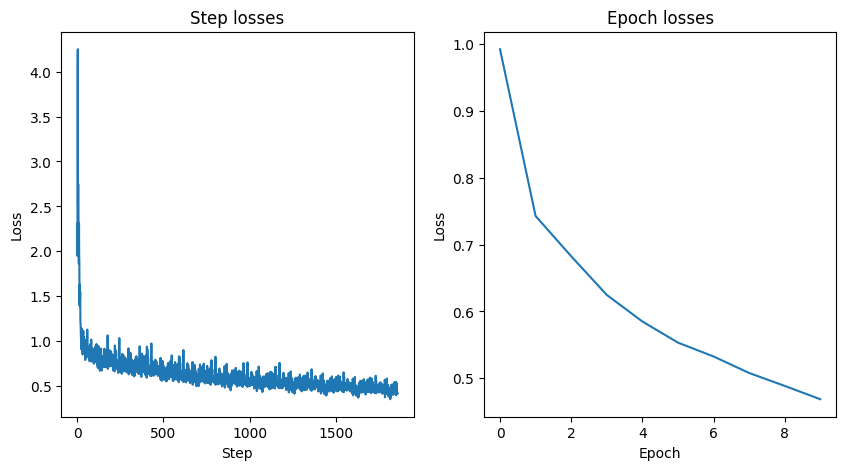

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

axes[0].set_title('Step losses')
axes[1].set_title('Epoch losses')

axes[0].set_xlabel('Step')
axes[1].set_xlabel('Epoch')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('Loss')

In [27]:
unet_name = "U-Net.pth"
torch.save(model.state_dict(), unet_name)

# Check predictions

In [28]:
unet_path = "U-Net.pth"
unet_model_ = UNet(num_classes=num_classes).to(device)
unet_model_.load_state_dict(torch.load(unet_path))

<All keys matched successfully>

In [29]:
test_batch_size = 8
dataset = CityDataset(os.path.join('cityscapes_data', 'val'), label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [30]:
X, Y = iter(data_loader).__next__()
X, Y = X.to(device), Y.to(device)
Y_pred = unet_model_(X)
print(f'Raw Y predicted shape: {Y_pred.shape}')
Y_pred = torch.argmax(Y_pred, dim=1)
print(f'Y predicted shape with torch argmax: {Y_pred.shape}')

Raw Y predicted shape: torch.Size([8, 10, 256, 256])
Y predicted shape with torch argmax: torch.Size([8, 256, 256])


In [31]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

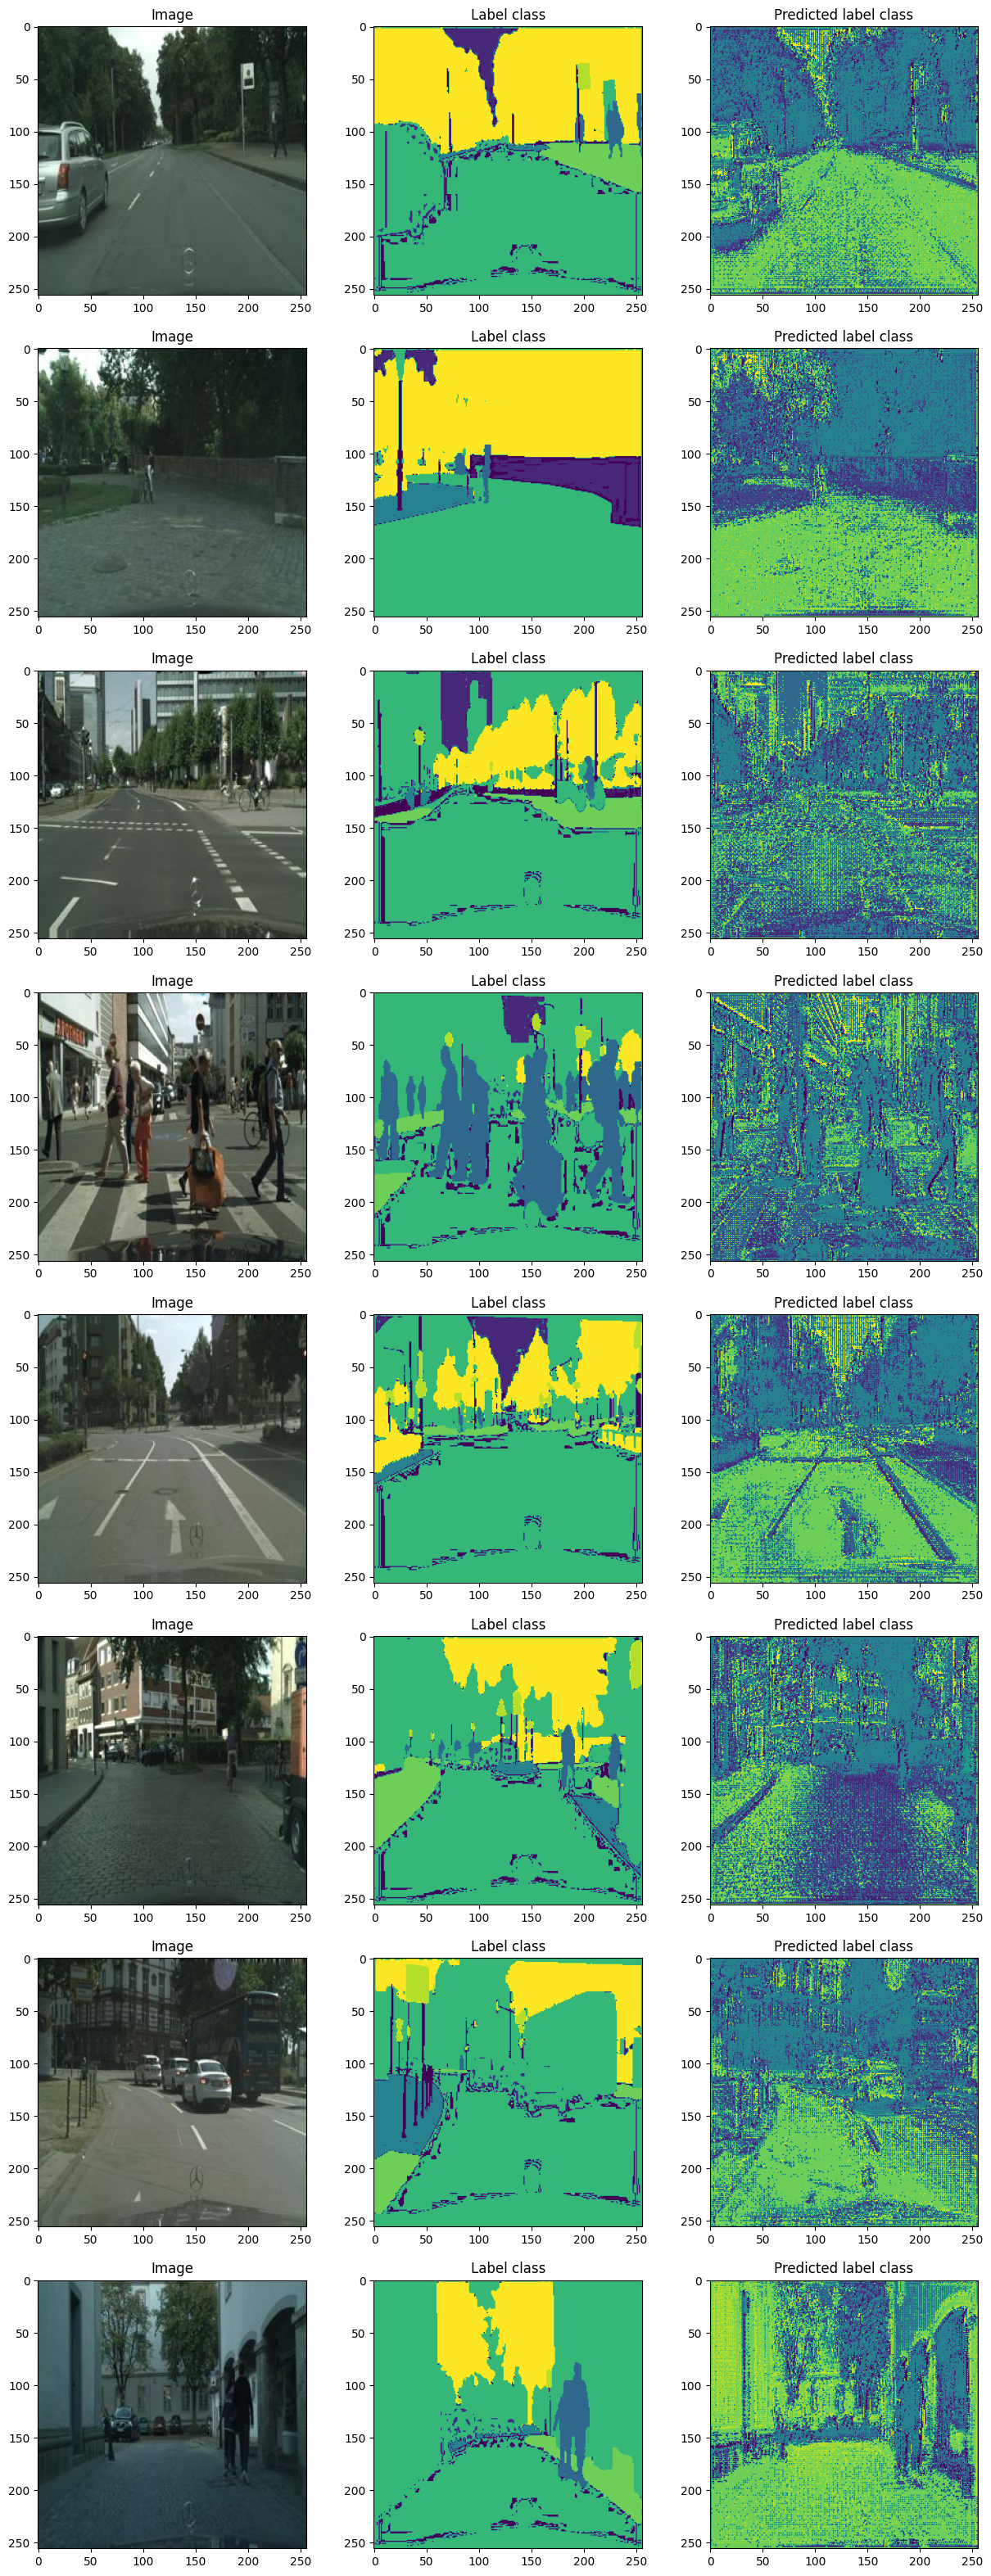

In [32]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Image")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Predicted label class")